# Assess Active Learning Effectiveness
See if an active learning optimization gets better candidates than a conventional search.

In [1]:
%matplotlib inline
from moldesign.score.mpnn import evaluate_mpnn, update_mpnn, custom_objects, MPNNMessage, GraphLoader
from moldesign.store.mongo import MoleculePropertyDB
from moldesign.store.models import MoleculeData
from matplotlib import pyplot as plt
from datetime import datetime
from pathlib import Path
from scipy import stats
import tensorflow as tf
import pandas as pd
import numpy as np
import json

RDKit WARNING: [18:11:18] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
mpnn_config = '/lus/theta-fs0/projects/CSC249ADCD08/edw/ai-components/sc-2021/mpnn'

## Load Runs
Get the data from the production-level runs that are run with 128 nodes

In [3]:
runs = list(Path("prod-runs").glob("*"))

In [4]:
def get_run_data(path: Path):
    """Get the data about a run
    
    Args:
        path: Path to the run
    Returns:
        (dict) Data about the run
    """
    
    # Get the basic information
    output = dict(path=path, study=path.name.split("_")[-1])
    with open(path.joinpath('run_params.json')) as fp:
        run_params = json.load(fp)
    output['num_nodes'] = run_params['nnodes']
    output['init_models'] = run_params['mpnn_model_files']
    for k in ['random', 'retrain_frequency']:
        output[k] = run_params[k]
    
    # Get the start-time
    with open(path.joinpath('runtime.log')) as fp:
        line = fp.readline().strip()
        start_time = datetime.strptime(line.split(" - ")[0].strip(), "%Y-%m-%d %H:%M:%S,%f")
    
    # Get the molecules that were scanned
    with open(path.joinpath('moldata-records.json')) as fp:
        records = [
            json.loads(x)  # First record is the save time
            for x in fp
        ]
        output['time'] = [(datetime.fromtimestamp(x[0]) - start_time).total_seconds() for x in records]
        mol_data = [json.loads(x[1]) for x in records]
    output['molecules'] = [x['identifier']['smiles'] for x in mol_data]
    output['ip'] = [x['oxidation_potential'].get('smb-vacuum') for x in mol_data]
    return output

In [5]:
results = pd.DataFrame([get_run_data(x) for x in runs]).query('num_nodes==256 and not random and retrain_frequency<1000')
print(f'Found {len(results)} matching runs')

Found 1 matching runs


## Get a Test Set
Get the molecules from the 256-node random search that are not in any of the test sets

In [6]:
path = Path('./prod-runs/256-nodes_random/')

In [7]:
random_run = get_run_data(path)

Filter out the molecules that have been searched

In [8]:
to_exclude = set(sum(results['molecules'], []))
print(f'Found {len(to_exclude)} molecules to exclude')

Found 356 molecules to exclude


In [9]:
test_set = pd.DataFrame([
    (sm, ip) for sm, ip in zip(random_run["molecules"], random_run["ip"])
    #if sm not in to_exclude
], columns=['smiles', 'ip'])
print(f'Pulled a test set of {len(test_set)} molecules')

Pulled a test set of 185 molecules


## Evaluate the initial models
How is the model performance before we do any retraining

In [10]:
with open(Path(mpnn_config).joinpath('atom_types.json')) as fp:
    atom_types = json.load(fp)

In [11]:
with open(Path(mpnn_config).joinpath('bond_types.json')) as fp:
    bond_types = json.load(fp)

In [12]:
test_set['init_predictions'] = evaluate_mpnn(results['init_models'].iloc[0], test_set['smiles'], atom_types, bond_types).mean(axis=1)

/lus/theta-fs0/projects/CSC249ADCD08/edw/env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/lus/theta-fs0/projects/CSC249ADCD08/edw/env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/lus/theta-fs0/projects/CSC249ADCD08/edw/env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/lus/theta-fs0/project

## Evaluate the Final Models from Each Study
See how the performances change with retraining

In [13]:
for study, path in results[['study', 'path']].values:
    # Get the models
    models = list(path.joinpath('models').glob("*.h5"))
    
    # Get the predictions
    test_set[study] = evaluate_mpnn(models, test_set['smiles'], atom_types, bond_types).mean(axis=1)

/lus/theta-fs0/projects/CSC249ADCD08/edw/env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/lus/theta-fs0/projects/CSC249ADCD08/edw/env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/lus/theta-fs0/projects/CSC249ADCD08/edw/env/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/lus/theta-fs0/project

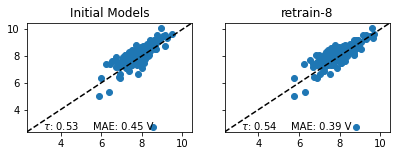

In [14]:
fig, axs = plt.subplots(1, len(results) + 1, figsize=(6.5, 2.), sharey=True)

axs[0].scatter(test_set['init_predictions'], test_set['ip'])
axs[0].set_title('Initial Models')
axs[0].text(0.4, 0.02, f"MAE: {(test_set['init_predictions'] - test_set['ip']).abs().mean():.2f} V", transform=axs[0].transAxes)
axs[0].text(0.1, 0.02, f"$\\tau$: {stats.kendalltau(test_set['init_predictions'], test_set['ip'])[0]:.2f}", transform=axs[0].transAxes)

for study, ax in zip(results['study'], axs[1::]):
    ax.scatter(test_set[study], test_set['ip'])
    ax.set_title(study)
    ax.text(0.4, 0.02, f"MAE: {(test_set[study] - test_set['ip']).abs().mean():.2f} V", transform=ax.transAxes)
    ax.text(0.1, 0.02, f"$\\tau$: {stats.kendalltau(test_set[study], test_set['ip'])[0]:.2f}", transform=ax.transAxes)
    
for ax in axs:
    ax.set_xlim(axs[0].get_ylim())
    ax.set_ylim(axs[0].get_ylim())
    
    ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')